In [1]:
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

def chatgpt_web_analysis(dataset, prompt_name, prompt_abb, round_=1):
    ## Read dump
    with open(f'dump-web-chat/conversations.json', mode='r', encoding='utf-8') as f:
        chats = {chat['title']: chat for chat in json.load(f)}
    
    # container
    prompts, answers = list(), list()

    count = -1
    for k, v in chats[f'{dataset}-{prompt_name}']['mapping'].items():
        count+=1

        # empty messages to establish connection
        if count < 2:
            continue

        v = v['message']

        # split messagges into prompt and answers
        try:
            if v['author']['role'] == 'user':
                prompts.append(v['content']['parts'][0])
            elif v['author']['role'] == 'assistant':
                answers.append(v['content']['parts'][0])
        except:
            print(f'Something wrong with the {count}-th data:', k, v)
    return prompts, answers

def handle_unresponded_answers(dataset, prompt_abb, prompts, answers, verbose=False, return_n_failure=False):
    # Unaddressed responses are incorrect answers.
    
    n_failure = 0
    
    idx_prompt = 0 # prompt index
    
    # containers
    new_prompts, new_answers = list(), list()
    
    # read data and expected value
    with open(f'prompt-data/{dataset}/{prompt_abb}.txt', mode='r', encoding='utf-8') as f:
        lines = [line.replace('##newline##', '\n').replace('_vb', '').replace('_nn', '') for line in f.readlines()]
    
    idx_gold = 0
    with open(f'prompt-truth/{dataset}/truth.txt', mode='r', encoding='utf-8') as f:
        gold = [int(g) for g in f.readlines()]
    
    for j, line in enumerate(lines):
        if prompts[idx_prompt] == line:
            if idx_prompt > 0 and not line.startswith('This is an example.') and not line.startswith('Task: Determine'):
                new_prompts.append(prompts[idx_prompt])
                answers[idx_prompt] = answers[idx_prompt].title().translate(str.maketrans('', '', string.punctuation))
                
                try:
                    # answer in right format
                    new_answers.append(int(eval(answers[idx_prompt])))
                except:
                    if verbose:
                        print(answers[idx_prompt])
                    # answer in bad format
                    n_failure+=1
                    new_answers.append(int(not gold[idx_gold]))
                idx_gold+=1
            idx_prompt+=1
        else:
            # probably there was an error on the server and the prompt wasn't answered
            if not line.startswith('This is an example.') and not line.startswith('Task: Determine'):
                new_prompts.append(line)
                new_answers.append(int(not gold[idx_gold]))
                n_failure+=1
        
    if return_n_failure:
        return new_prompts, new_answers, n_failure
    else:
        return new_prompts, new_answers



def chatgpt_api_analysis(dataset, prompt_abb, temperature, round_=1):
    '''Align prompts with answers'''
    
    with open(f'chatgpt-conversations{round_}/{dataset}/{prompt_abb}/{temperature}.json', mode='r', encoding='utf-8') as f:
        chat = json.load(f)
        
    prompts = list()
    answers = list()

    for i, message in enumerate(chat):

        # empty messages to establish connection
        if i < 1:
            continue

        if i%2!=0:
            prompts.append(message['content'])
        else:
            answers.append(message['content'])
        
    return prompts, answers

def metrics(dataset, answers):
    with open(f'prompt-truth/{dataset}/test.txt', mode='r', encoding='utf-8') as f:
        gold = [int(g) for g in f.readlines()]
    
    return round(accuracy_score(gold, answers), 3), round(f1_score(gold, answers, average='weighted'), 3), gold   

In [2]:
def performance_dataframe(round_=1):
    df = list()

    for dataset in ['TempoWiC', 'HistoWiC']:
        for prompt_abb, prompt_name in {'zsp':'zero-shot', 'fsp': 'few-shot', 'msp': 'many-shot'}.items():
            # ChatGPT - Web
            prompts, answers = chatgpt_web_analysis(dataset, prompt_name, prompt_abb)
            prompts, answers, n_failure = handle_unresponded_answers(dataset, prompt_abb, prompts, answers, verbose=False, return_n_failure=True)
            acc, f1, gold = metrics(dataset, answers)

            record = dict(model='ChatGPT Web', 
                          dataset=dataset, 
                          prompt=prompt_abb, 
                          gold=gold, 
                          answers=answers, 
                          temperature='unknown', 
                          n_failure=n_failure, 
                          acc=acc,
                          f1=f1)
            df.append(record)

            if prompt_abb == 'msp':
                continue

            # ChatGPT - API
            for temperature in np.arange(0.0, 2.2, 0.2):
                temperature = round(temperature, 1)
                prompts, answers = chatgpt_api_analysis(dataset, prompt_abb, temperature, round_=round_)
                prompts, answers, n_failure = handle_unresponded_answers(dataset, prompt_abb, prompts, answers, verbose=False, return_n_failure=True)
                acc, f1, gold = metrics(dataset, answers)
                record = dict(model='ChatGPT API', 
                              dataset=dataset, 
                              prompt=prompt_abb, 
                              gold=gold, 
                              answers=answers,
                              temperature=temperature, 
                              n_failure=n_failure, 
                              acc=acc, 
                              f1=f1)
                df.append(record)

        # BERT 
        bert = pd.read_csv(f'data/{dataset}/wic_stats.tsv', sep='\t')
        for _, row in bert.iterrows():
            if row['layer']=='8-12': continue
            record = dict(model='BERT',
                          dataset=dataset,
                          prompt='none',
                          gold=gold,
                          answers=eval(row['test_preds']),
                          temperature=int(row['layer']), 
                          n_failure=0, 
                          acc=row['acc_test'],
                          f1=row['f1_test'])
            df.append(record)
    
    return pd.DataFrame(df)

    ## histotempowic
    for dataset in ['HistoTempoWiC']:
        for prompt_abb, prompt_name in {'zsp':'zero-shot'}.items():
            # ChatGPT - API
            for temperature in np.arange(0.0, 2.2, 0.2):
                temperature = round(temperature, 1)
                prompts, answers = chatgpt_api_analysis(dataset, prompt_abb, temperature, round_=round_)
                prompts, answers, n_failure = handle_unresponded_answers(dataset, prompt_abb, prompts, answers, verbose=False, return_n_failure=True)
                acc, f1, gold = metrics(dataset, answers)
                record = dict(model='ChatGPT API', 
                              dataset=dataset, 
                              prompt=prompt_abb, 
                              gold=gold, 
                              answers=answers,
                              temperature=temperature, 
                              n_failure=n_failure, 
                              acc=acc, 
                              f1=f1)
                df.append(record)

        # BERT 
        bert = pd.read_csv(f'data/{dataset}/wic_stats.tsv', sep='\t')
        for _, row in bert.iterrows():
            if row['layer']=='8-12': continue
            record = dict(model='BERT',
                          dataset=dataset,
                          prompt=None,
                          gold=gold,
                          answers=eval(row['test_preds']),
                          temperature=int(row['layer']), 
                          n_failure=0, 
                          acc=row['acc_test'],
                          f1=row['f1_test'])
            df.append(record)
    
    return pd.DataFrame(df)

<b> RQ1 :</b> <i>Can we evaluate ChatGPT in WiC tasks completely in an automatic way?</i>

In [3]:
# do you have more rounds?
n_rounds = 2

In [4]:
dfs = list()
for i in range(1, n_rounds+1):
    df = performance_dataframe(round_=i)
    df['round'] = i    
    dfs.append(df)

if i > 1:
    main_df = pd.concat(dfs)
else:
    main_df = dfs[0]

In [5]:
df = main_df.astype(str).groupby(['model', 'prompt', 'dataset', 'round'])['n_failure'].apply(','.join).reset_index()
df_mean = main_df.groupby(['model', 'dataset', 'temperature']).mean().reset_index()
df_mean = df_mean.astype(str).groupby(['model', 'dataset'])['n_failure'].apply(','.join).reset_index()

C:\Users\Francesco Periti\AppData\Local\Temp\ipykernel_17112\1956231348.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = main_df.groupby(['model', 'dataset', 'temperature']).mean().reset_index()


Text(0.5, 0, 'Temperature')

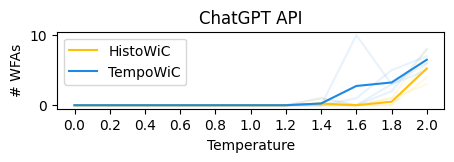

In [6]:
def get_failure_arr(model, dataset, prompt, round_, mean=False):
    if not mean:
        arr = df[(df['model']==model) & (df['dataset']==dataset) & (df['prompt']==prompt) & (df['round']==str(round_))].n_failure.values
        arr = arr[0]
    else:
        arr = df_mean[(df_mean['model']==model) & (df_mean['dataset']==dataset)].n_failure.values
        arr = arr[0]
    return np.array([float(i) for i in arr.split(',')])

temperatures = [round(t, 1) for t in np.arange(0, 2.2, 0.2)]

colors = ['#1E88E5', '#FFC107']

plt.figure(figsize=(5, 1))
for i in range(1, n_rounds+1): 
    plt.plot(temperatures, get_failure_arr('ChatGPT API', 'TempoWiC', 'zsp', i), alpha=0.1, color=colors[0])
    plt.plot(temperatures, get_failure_arr('ChatGPT API', 'TempoWiC', 'fsp', i), alpha=0.1, color=colors[0])
    plt.plot(temperatures, get_failure_arr('ChatGPT API', 'HistoWiC', 'zsp', i), alpha=0.1, color=colors[1])
    plt.plot(temperatures, get_failure_arr('ChatGPT API', 'HistoWiC', 'fsp', i), alpha=0.1, color=colors[1])

plt.plot(temperatures, get_failure_arr('ChatGPT API', 'HistoWiC', None, None, True), alpha=1, color=colors[1], label='HistoWiC')
plt.plot(temperatures, get_failure_arr('ChatGPT API', 'TempoWiC', None, None, True), alpha=1, color=colors[0], label='TempoWiC')
plt.legend()

_ = plt.xticks(temperatures)
plt.title('ChatGPT API')
plt.ylabel('# WFAs')
plt.xlabel('Temperature')

Note that this wrong answer is due to ethich issues with a specific instance

C:\Users\Francesco Periti\AppData\Local\Temp\ipykernel_17112\3314688159.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df[df['model']=='ChatGPT Web'].groupby(['dataset', 'prompt']).mean().reset_index()


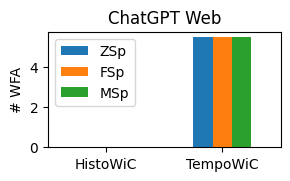

In [7]:
gptweb = list()

df_plot = df[df['model']=='ChatGPT Web'].groupby(['dataset', 'prompt']).mean().reset_index()

gptweb.append(dict(dataset='TempoWiC',
              ZSp=df_plot[(df_plot['dataset']=='TempoWiC') & (df_plot['prompt']=='zsp')]['n_failure'],
              FSp=df_plot[(df_plot['dataset']=='TempoWiC') & (df_plot['prompt']=='fsp')]['n_failure'],
              MSp=df_plot[(df_plot['dataset']=='TempoWiC') & (df_plot['prompt']=='msp')]['n_failure']))
gptweb.append(dict(dataset='HistoWiC',
              ZSp=df_plot[(df_plot['dataset']=='HistoWiC') & (df_plot['prompt']=='zsp')]['n_failure'],
              FSp=df_plot[(df_plot['dataset']=='HistoWiC') & (df_plot['prompt']=='fsp')]['n_failure'],
              MSp=df_plot[(df_plot['dataset']=='HistoWiC') & (df_plot['prompt']=='msp')]['n_failure']))

gptweb = pd.DataFrame(gptweb)
ax = gptweb.groupby(['dataset']).mean().plot(kind='bar', xlabel='', ylabel='# WFA', title='ChatGPT Web', figsize=(3, 1.5), rot=0)

<b> RQ2: </b> <i> Can we enhance ChatGPT’s performance in semantic shift detection by leveraging its in-context learning capabilities? </i>

In [8]:
df = main_df
df = df.groupby(['model', 'dataset', 'prompt', 'temperature']).mean().reset_index()

C:\Users\Francesco Periti\AppData\Local\Temp\ipykernel_17112\1048265500.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['model', 'dataset', 'prompt', 'temperature']).mean().reset_index()


Text(0.5, 0, 'Temperature')

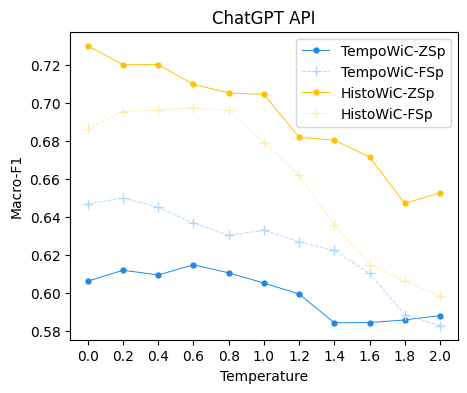

In [9]:
new_df = pd.DataFrame()
new_df['TempoWiC-ZSp'] = df[(df['model'] == 'ChatGPT API') & (df['prompt'] == 'zsp') & (df['dataset'] == 'TempoWiC')].sort_values('temperature').f1.values
new_df['TempoWiC-FSp'] = df[(df['model'] == 'ChatGPT API') & (df['prompt'] == 'fsp') & (df['dataset'] == 'TempoWiC')].sort_values('temperature').f1.values
new_df['HistoWiC-ZSp'] = df[(df['model'] == 'ChatGPT API') & (df['prompt'] == 'zsp') & (df['dataset'] == 'HistoWiC')].sort_values('temperature').f1.values
new_df['HistoWiC-FSp'] = df[(df['model'] == 'ChatGPT API') & (df['prompt'] == 'fsp') & (df['dataset'] == 'HistoWiC')].sort_values('temperature').f1.values

temperatures = [round(t, 1) for t in np.arange(0, 2.2, 0.2)]

colors = ['#1E88E5', '#AFD9FF', '#FFC107', '#FFEBAF']
shapes = ['.', '+', '.', '+']
linestyle = ['-', '--', '-', '--']

plt.figure(figsize=(5, 4))
for i, col in enumerate(new_df.columns.values):
    scores = new_df[col].rolling(4, center=True, min_periods=2).mean()
    plt.plot(temperatures, scores, 
             linestyle=linestyle[i], 
             color=colors[i], marker=shapes[i], markersize=7, linewidth=0.7, label=col)

df_gpt = new_df.copy()
    
_ = plt.xticks(temperatures)
plt.legend()
plt.title('ChatGPT API')
plt.ylabel('Macro-F1')
plt.xlabel('Temperature')

C:\Users\Francesco Periti\AppData\Local\Temp\ipykernel_17112\2654258932.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df[df['model']=='ChatGPT Web'].groupby(['dataset', 'prompt']).mean().reset_index()


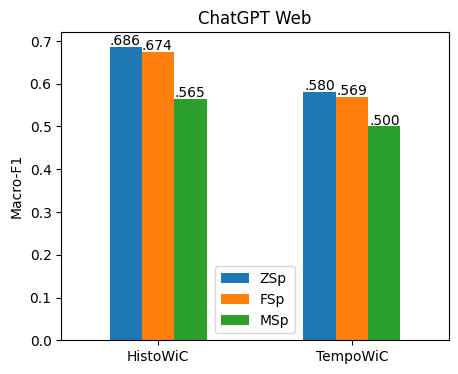

In [10]:
gptweb = list()

df_plot = df[df['model']=='ChatGPT Web'].groupby(['dataset', 'prompt']).mean().reset_index()

gptweb.append(dict(dataset='TempoWiC',
              ZSp=df_plot[(df_plot['dataset']=='TempoWiC') & (df_plot['prompt']=='zsp')]['f1'],
              FSp=df_plot[(df_plot['dataset']=='TempoWiC') & (df_plot['prompt']=='fsp')]['f1'],
              MSp=df_plot[(df_plot['dataset']=='TempoWiC') & (df_plot['prompt']=='msp')]['f1']))
gptweb.append(dict(dataset='HistoWiC',
              ZSp=df_plot[(df_plot['dataset']=='HistoWiC') & (df_plot['prompt']=='zsp')]['f1'],
              FSp=df_plot[(df_plot['dataset']=='HistoWiC') & (df_plot['prompt']=='fsp')]['f1'],
              MSp=df_plot[(df_plot['dataset']=='HistoWiC') & (df_plot['prompt']=='msp')]['f1']))

gptweb = pd.DataFrame(gptweb)
ax = gptweb.groupby(['dataset']).mean().plot(kind='bar', xlabel='', ylabel='Macro-F1', title='ChatGPT Web', figsize=(5, 4), rot=0)
for p in ax.patches:
    ax.annotate('{:.3f}'.format(round(p.get_height(), 3)).replace('0.', '.'), (p.get_x() * 1.005, p.get_height() * 1.008))

<b> Min Max Performances </b>

In [11]:
print('TempoWiC', 
      main_df[(main_df['dataset'] == 'TempoWiC') & (main_df['model'] == 'ChatGPT API')].sort_values(by='f1')[['f1']].min()[0])
print('TempoWiC', 
      main_df[(main_df['dataset'] == 'TempoWiC') & (main_df['model'] == 'ChatGPT API')].sort_values(by='f1')[['f1']].max()[0])
print('HistoWiC', 
      main_df[(main_df['dataset'] == 'HistoWiC') & (main_df['model'] == 'ChatGPT API')].sort_values(by='f1')[['f1']].min()[0])
print('HistoWiC', 
      main_df[(main_df['dataset'] == 'HistoWiC') & (main_df['model'] == 'ChatGPT API')].sort_values(by='f1')[['f1']].max()[0])

TempoWiC 0.551
TempoWiC 0.689
HistoWiC 0.552
HistoWiC 0.765


<b> RQ5: </b>

In [12]:
def get_class(temp, range_=(0, 1)):
    return range_[0] <= temp <= range_[1]

def api_web_comparison():
    res = list()
    for p in ['zsp', 'fsp']:
        for dataset in ['TempoWiC', 'HistoWiC']:
            for range_ in [(0, 1), (1, 2), (0, 2)]:
                api_web = main_df.copy()
                api_web['mask'] = [1 if main_df.iloc[i].model == 'ChatGPT API' and get_class(main_df.iloc[i].temperature, range_=range_) else 0 for i in range(main_df.shape[0])]
                f1 = api_web[(api_web['mask'] == 1) & (api_web['dataset'] == dataset) & (api_web['prompt'] == p)]['f1'].mean()
                res.append(dict(dataset=dataset, temp_class=range_, f1=f1, prompt=p))
    
    for dataset in ['TempoWiC', 'HistoWiC']:
        for range_ in [(0, 1), (1, 2), (0, 2)]:
            api_web = main_df.copy()
            api_web['mask'] = [1 if main_df.iloc[i].model == 'ChatGPT API' and get_class(main_df.iloc[i].temperature, range_=range_) else 0 for i in range(main_df.shape[0])]
            f1 = api_web[(api_web['mask'] == 1) & (api_web['dataset'] == dataset)]['f1'].mean()
            res.append(dict(dataset=dataset, temp_class=range_, f1=f1, prompt='all'))
    
    api_web = main_df.copy()
    api_web = api_web[api_web['model'] == 'ChatGPT Web']
    for _, row in api_web.iterrows():
        res.append(dict(dataset=row['dataset'], temp_class='', f1=row['f1'], prompt=row['prompt']))
    
    return pd.DataFrame(res).round(3).drop_duplicates()

In [13]:
api_web_comparison()

,dataset,temp_class,f1,prompt
0,TempoWiC,"(0, 1)",0.609,zsp
1,TempoWiC,"(1, 2)",0.589,zsp
2,TempoWiC,"(0, 2)",0.600,zsp
3,HistoWiC,"(0, 1)",0.713,zsp
4,HistoWiC,"(1, 2)",0.665,zsp
5,HistoWiC,"(0, 2)",0.688,zsp
6,TempoWiC,"(0, 1)",0.636,fsp
7,TempoWiC,"(1, 2)",0.606,fsp
8,TempoWiC,"(0, 2)",0.622,fsp
9,HistoWiC,"(0, 1)",0.693,fsp


<b> RQ7: </b>

Text(0.5, 0, 'Layers')

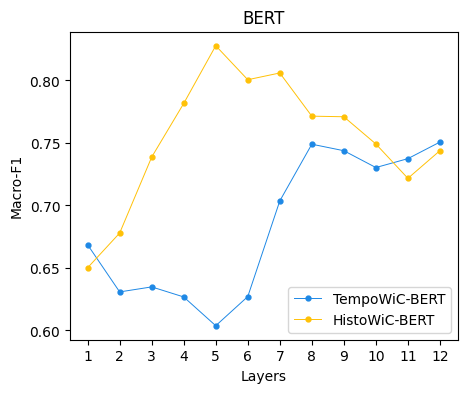

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

new_df = pd.DataFrame()
new_df['TempoWiC-BERT'] = df[(df['model'] == 'BERT') & (df['dataset'] == 'TempoWiC')].sort_values('temperature').f1.values
new_df['HistoWiC-BERT'] = df[(df['model'] == 'BERT') & (df['dataset'] == 'HistoWiC')].sort_values('temperature').f1.values

layers = list(range(1,13))

colors = ['#1E88E5', '#FFC107']
shapes = ['.', '.']
linestyle = ['-', '-']

plt.figure(figsize=(5, 4))
for i, col in enumerate(new_df.columns.values):
    scores = new_df[col].values #rolling(3, center=True, min_periods=2).mean()
    plt.plot(layers, scores, 
             linestyle=linestyle[i], 
             color=colors[i], marker=shapes[i], markersize=7, linewidth=0.7, label=col)

df_bert = new_df.copy()

_ = plt.xticks(layers)
plt.legend()
plt.title('BERT')
plt.ylabel('Macro-F1')
plt.xlabel('Layers')

In [15]:
gold = main_df[(main_df['model'] == 'BERT') & (main_df['temperature'] == 5) & (main_df['dataset'] == 'HistoWiC')].gold.values[0]
answer5 = main_df[(main_df['model'] == 'BERT') & (main_df['temperature'] == 5) & (main_df['dataset'] == 'HistoWiC')].answers.values[0]
answer12 = main_df[(main_df['model'] == 'BERT') & (main_df['temperature'] == 12) & (main_df['dataset'] == 'HistoWiC')].answers.values[0]
prompts = open(f'prompt-data/HistoWiC/zsp.txt', mode='r', encoding='utf-8').readlines()[1:]

In [16]:
i=0
for a, b, g in zip(answer5, answer12, gold):
    if a!=b and a == g:
        tmp = prompts[i].replace("""Now it's your turn. You have to answer with "True" or "False"##newline##""", '')
        tmp = tmp.replace("Question: Do the target word in both sentences have the same meaning in their respective contexts?##newline##Answer:", '')
        tmp = tmp.replace('##newline##', '\n')[:-2]
        print(tmp, g, '\n')
    i+=1

Sentence 1: " not if you'll let me lay my heels at your fire.
Sentence 2: At your seat, point your toes down (heels up), then raise your toes up toward your knees so that you're flexing your calf muscles, suggests Rebecca W. Acosta, MPH, executive director of Traveler
Target: heel_nn
 1 

Sentence 1: It was then pretty late in the afternoon of a short day, and I felt a little uneasy about the chances of missing my way, should the night overtake me.
Sentence 2: By afternoon he was out of a job; he was also codefendant, with his paper, in a suit for assault and battery.
Target: afternoon_nn
 1 

Sentence 1: Officer Stab, stab, again: but heaven supports my soul To warn thee, O thou Upas of the world, Thou scourge of God -- that soon thy reign will end.
Sentence 2: Only twelve miles to go, " he tells Tinkerbelle, whom he regarded throughout as " my dearest companion, " and then he adds: " The thought brought on a faint stabbing of pain. "
Target: stab_nn
 0 

Sentence 1: Bits of artificia

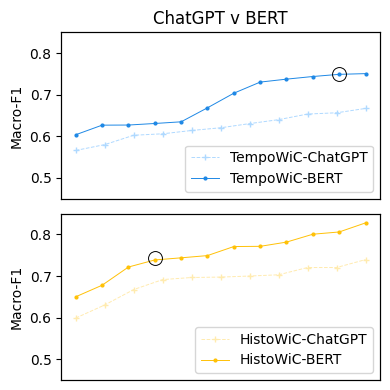

In [17]:
fig, ax = plt.subplots(2, figsize=(4, 4))
ay = ax[0].twiny()
ay1 = ax[1].twiny()
ax[0].plot(temperatures, sorted(df_gpt['TempoWiC-FSp'].values), color='#AFD9FF', markersize=4, linewidth=0.7, label='TempoWiC-ChatGPT', marker='+', linestyle='--')
ay.plot(layers, sorted(df_bert['TempoWiC-BERT'].values), color='#1E88E5', markersize=4, linewidth=0.7, label='TempoWiC-BERT', marker='.', linestyle='-')
ax[1].plot(temperatures, sorted(df_gpt['HistoWiC-ZSp']), color='#FFEBAF', markersize=4, linewidth=0.7, label='HistoWiC-ChatGPT', marker='+', linestyle='--')
ay1.plot(layers, sorted(df_bert['HistoWiC-BERT'].values), color='#FFC107', markersize=4, linewidth=0.7, label='HistoWiC-BERT', marker='.', linestyle='-')
ay1.plot(sorted(df_bert['HistoWiC-BERT'].values).index(df_bert['HistoWiC-BERT'].values[-1]), df_bert['HistoWiC-BERT'].values[-1], 'o', 
            markerfacecolor="None", markeredgecolor='black', markeredgewidth=0.7, ms=10)
ay.plot(sorted(df_bert['TempoWiC-BERT'].values).index(df_bert['TempoWiC-BERT'].values[-1]), df_bert['TempoWiC-BERT'].values[-1], 'o', 
            markerfacecolor="None", markeredgecolor='black', markeredgewidth=0.7, ms=10)

h1, l1 = ax[0].get_legend_handles_labels()
h2, l2 = ay.get_legend_handles_labels()
ax[0].legend(h1+h2, l1+l2, loc="lower right")

h1, l1 = ax[1].get_legend_handles_labels()
h2, l2 = ay1.get_legend_handles_labels()
ax[1].legend(h1+h2, l1+l2, loc="lower right")
#ax[1].set_xlabel('ChatGPT temperature')
#ax[0].set_xlabel('ChatGPT temperature')
ax[0].set_ylabel('Macro-F1')
ax[1].set_ylabel('Macro-F1')
ax[1].set_xticks([])
ax[0].set_xticks([])
#ax[1].set_xticks(temperatures[::-1])
#ax[0].set_xticks(temperatures[::-1])
#ay.set_xlabel('BERT layer')
#ay1.set_xlabel('BERT layer')
#ay.set_xticks(layers)
#ay1.set_xticks(layers)
ay.set_xticks([])
ay1.set_xticks([])
ay.set_ylim(0.45, 0.85)
ay1.set_ylim(0.45, 0.85)
ay.set_title('ChatGPT v BERT')
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import recall_score

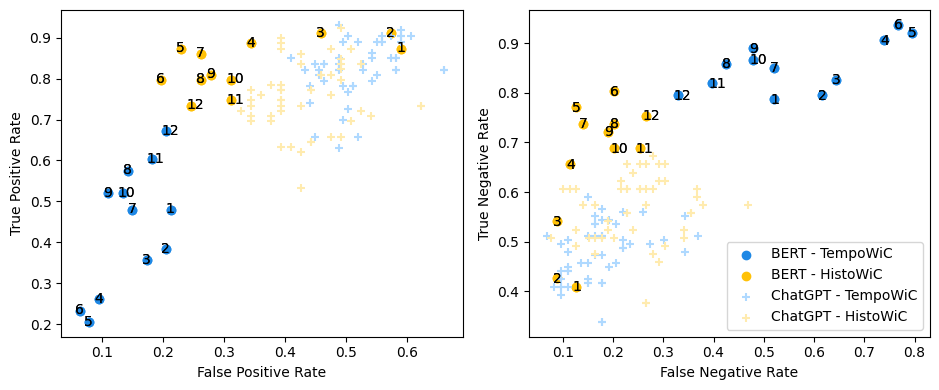

In [19]:
df = main_df
df_stats = list()

fig, axs = plt.subplots(1, 2, figsize=(9.5, 4))

colors = ['#1E88E5', '#FFC107']

for i, dataset in enumerate(['TempoWiC', 'HistoWiC']):
    gold = df[df['dataset'] == dataset].iloc[0].gold
    bert = np.array([v for v in df[(df['model'] == 'BERT') & (df['dataset'] == dataset)].answers.values])
    bert_tpr, bert_fpr = list(),  list()
    bert_tnr, bert_fnr = list(),  list()
    
    for layer in range(bert.shape[0]):
        tmp = bert[layer]
        tpr = recall_score(gold, tmp)
        tnr = recall_score(gold, tmp, pos_label = 0) 
        fnr = 1 - tpr
        fpr = 1 - tnr
        bert_tpr.append(tpr)
        bert_fpr.append(fpr)
        bert_tnr.append(tnr)
        bert_fnr.append(fnr)
    
    axs[0].scatter(bert_fpr, bert_tpr, color=colors[i], label=f'BERT - {dataset}', marker='o', alpha=1)
    axs[1].scatter(bert_fnr, bert_tnr, color=colors[i], label=f'BERT - {dataset}', marker='o', alpha=1)
    
    layers = np.array([str(layer) for layer in df[(df['model'] == 'BERT') & (df['dataset'] == dataset)].temperature.values])
    for i, txt in enumerate(layers):
        axs[0].annotate(txt, (bert_fpr[i]-0.008, bert_tpr[i]-0.009))
        axs[1].annotate(txt, (bert_fnr[i]-0.008, bert_tnr[i]-0.009))

colors = ['#AFD9FF', '#FFEBAF']

for i, dataset in enumerate(['TempoWiC', 'HistoWiC']):
    gold = df[df['dataset'] == dataset].iloc[0].gold
    
    gpt = np.array([v for v in df[(df['model'] != 'BERT') & (df['dataset'] == dataset)].answers.values])
    gpt_tpr, gpt_fpr = list(),  list()
    gpt_tnr, gpt_fnr = list(),  list()
    for layer in range(gpt.shape[0]):
        tmp = gpt[layer]
        tpr = recall_score(gold, tmp)
        tnr = recall_score(gold, tmp, pos_label = 0) 
        fnr = 1 - tpr
        fpr = 1 - tnr
        gpt_tpr.append(tpr)
        gpt_fpr.append(fpr)
        gpt_tnr.append(tnr)
        gpt_fnr.append(fnr)
    
    axs[0].scatter(gpt_fpr, gpt_tpr, color=colors[i], label=f'ChatGPT - {dataset}', marker='+', alpha=1)
    axs[1].scatter(gpt_fnr, gpt_tnr, color=colors[i], label=f'ChatGPT - {dataset}', marker='+', alpha=1)
    

axs[1].set_xlabel('False Negative Rate')
axs[1].set_ylabel('True Negative Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()

In [20]:
df = main_df
df_stats = list()

for dataset in ['TempoWiC', 'HistoWiC']:
    prompts = open(f'prompt-data/{dataset}/zsp.txt', mode='r', encoding='utf-8').readlines()[1:]
    gold = df[df['dataset'] == dataset].iloc[0].gold
    
    #bert = df[(df['model'] == 'BERT') & (df['temperature'] == 8) & (df['dataset'] == dataset)].answers.values
    #bert = bert[0]
    bert = np.array([v for v in df[(df['model'] == 'BERT') & (df['dataset'] == dataset)].answers.values])
    bert_agreement = list()
    for i in range(bert.shape[1]):
        tmp = bert[:, i].tolist()
        bert_agreement.append(int(tmp.count(1) > tmp.count(0)))

    #chatgpt = df[(df['model'] == 'ChatGPT API') & (df['temperature'] == 0.8) & (df['dataset'] == dataset) & (df['prompt'] == 'zsp')].answers.values
    #chatgpt = chatgpt[0]
    prompt = 'zsp' if dataset == 'HistoWiC' else 'fsp'
    chatgpt = np.array([v for v in df[(df['model'] == 'ChatGPT API') & (df['dataset'] == dataset) & (df['prompt'] == prompt)].answers.values])
    chatgpt_agreement = list()
    for i in range(chatgpt.shape[1]):
        tmp = chatgpt[:, i].tolist()
        chatgpt_agreement.append(int(tmp.count(1) >= tmp.count(0)))

    chatgpt_bert = np.concatenate([chatgpt, bert])
    agreement = list()
    for i in range(chatgpt_bert.shape[1]):
        tmp = chatgpt_bert[:, i].tolist()
        agreement.append(int(tmp.count(1) >= tmp.count(0)))
        
    
    common_tp, common_tn = list(), list()
    common_fp, common_fn = list(), list()
    bert_tp, chatgpt_tp = list(), list()
    bert_tn, chatgpt_tn = list(), list()
    bert_fp, chatgpt_fp = list(), list()
    bert_fn, chatgpt_fn = list(), list()
    chatgpt_bert_tn, chatgpt_bert_tp = list(), list()
    chatgpt_bert_fn, chatgpt_bert_fp = list(), list()

    for i, g in enumerate(gold):
        if chatgpt_agreement[i] == bert_agreement[i] == g and g:
            common_tp.append(i)
            continue
        elif chatgpt_agreement[i] == bert_agreement[i] == g and not g:
            common_tn.append(i)
            continue
        elif chatgpt_agreement[i] == bert_agreement[i] != g and not g:
            common_fp.append(i)
            continue
        elif chatgpt_agreement[i] == bert_agreement[i] != g and g:
            common_fn.append(i)
            continue

        if g == bert_agreement[i] and g:
            bert_tp.append(i)
        elif g == bert_agreement[i] and not g:
            bert_tn.append(i)
        elif g != bert_agreement[i] and not g:
            bert_fp.append(i)
        elif g != bert_agreement[i] and g:
            bert_fn.append(i)

        if g == chatgpt_agreement[i] and g:
            chatgpt_tp.append(i)
        elif g == chatgpt_agreement[i] and not g:
            chatgpt_tn.append(i)
        elif g != chatgpt_agreement[i] and not g:
            chatgpt_fp.append(i)
        elif g != chatgpt_agreement[i] and g:
            chatgpt_fn.append(i)

        if g == agreement[i] and g:
            chatgpt_bert_tp.append(i)
        elif g == agreement[i] and not g:
            chatgpt_bert_tn.append(i)
        elif g != agreement[i] and not g:
            chatgpt_bert_fp.append(i)
        elif g != agreement[i] and g:
            chatgpt_bert_fn.append(i)

    chatgpt_acc = accuracy_score(gold, chatgpt_agreement)
    chatgpt_f1 = f1_score(gold, chatgpt_agreement, average='weighted')
    bert_acc = accuracy_score(gold, bert_agreement)
    bert_f1 = f1_score(gold, bert_agreement, average='weighted')
    chatgpt_bert_acc = accuracy_score(gold, agreement)
    chatgpt_bert_f1 = f1_score(gold, agreement, average='weighted')

    record = dict(model='ChatGPT',
                  dataset=dataset,
                  tp=chatgpt_tp,
                  tn=chatgpt_tn,
                  fp=chatgpt_fp,
                  fn=chatgpt_fn,
                  f1=chatgpt_f1,
                  acc=chatgpt_acc,
                  preds=chatgpt_agreement,
                  gold=gold,
                  prompts=prompts)
    df_stats.append(record)

    record = dict(model='BERT',
                  dataset=dataset,
                  tp=bert_tp,
                  tn=bert_tn,
                  fp=bert_fp,
                  fn=bert_fn,
                  f1=bert_f1,
                  acc=bert_acc,
                  preds=bert_agreement,
                  gold=gold,
                  prompts=prompts)
    df_stats.append(record)

    record = dict(model='Common',
                  dataset=dataset,
                  tp=len(common_tp),
                  tn=len(common_tn),
                  fp=len(common_fp),
                  fn=len(common_fn))
    df_stats.append(record)

    record = dict(model='Ensemble',
                  dataset=dataset,
                  tp=chatgpt_bert_tp,
                  tn=chatgpt_bert_tn,
                  fp=chatgpt_bert_fp,
                  fn=chatgpt_bert_fn,
                  f1=chatgpt_bert_f1,
                  acc=chatgpt_bert_acc,
                  preds=agreement,
                  gold=gold,
                  prompts=prompts)
    df_stats.append(record)

df_stats = pd.DataFrame(df_stats)

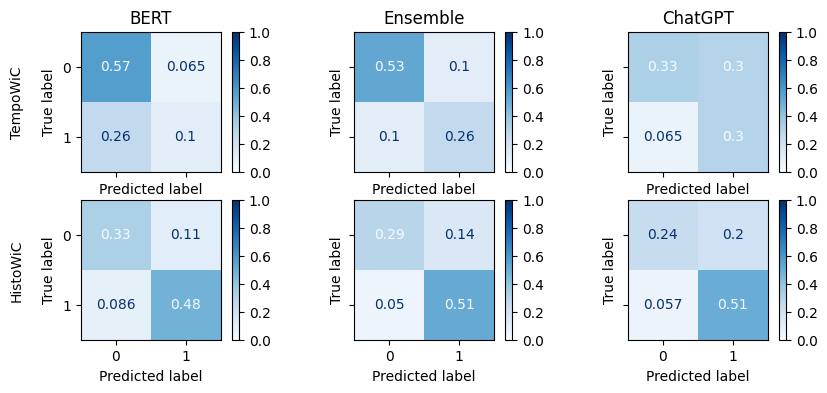

In [21]:
_, ax = plt.subplots(2, 3, figsize=(10, 4), sharey='row', sharex=True)

for i, dataset in enumerate(['TempoWiC', 'HistoWiC']):
    gold = np.array(df_stats[(df_stats['dataset'] == dataset) & (df_stats['model'] == 'BERT')].gold.values[0])
    bert_agreement = np.array(df_stats[(df_stats['dataset'] == dataset) & (df_stats['model'] == 'BERT')].preds.values[0])
    cm = confusion_matrix(gold, bert_agreement)/len(gold)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    if i == 0: ax[i][0].set_title('BERT')
    disp.plot(ax=ax[i][0], cmap=plt.cm.Blues)
    disp.im_.set_clim(0, 1)
    
    agreement = np.array(df_stats[(df_stats['dataset'] == dataset) & (df_stats['model'] == 'Ensemble')].preds.values[0])
    cm = confusion_matrix(gold, agreement)/len(gold)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    if i == 0: ax[i][1].set_title('Ensemble')
    disp.plot(ax=ax[i][1], cmap=plt.cm.Blues)
    disp.im_.set_clim(0, 1)
    
    chatgpt_agreement = np.array(df_stats[(df_stats['dataset'] == dataset) & (df_stats['model'] == 'ChatGPT')].preds.values[0])
    cm = confusion_matrix(gold, chatgpt_agreement)/len(gold)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[i][2], cmap=plt.cm.Blues)
    if i == 0: ax[i][2].set_title('ChatGPT')
    disp.im_.set_clim(0, 1)
    
    ax[i][0].set_ylabel(dataset+'\n\nTrue label')

In [22]:
df_stats.sort_values('f1', ascending=False)

,model,dataset,tp,tn,fp,fn,f1,acc,preds,gold,prompts
5,BERT,HistoWiC,"[16, 31, 35, 75, 101, 128]","[1, 8, 9, 13, 25, 33, 40, 48, 59, 67, 81, 84, ...","[17, 62, 73, 78, 91]","[6, 7, 24, 32, 60, 89, 94, 117, 126, 129]",0.806509,0.807143,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, ...","[Now it's your turn. You have to answer with ""..."
7,Ensemble,HistoWiC,"[6, 16, 31, 35, 60, 75, 94, 101, 126, 128, 129]","[1, 13, 25, 33, 40, 48, 62, 67, 84, 102, 116, ...","[8, 9, 17, 59, 73, 78, 81, 88, 91, 113]","[7, 24, 32, 89, 117]",0.802973,0.807143,"[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, ...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, ...","[Now it's your turn. You have to answer with ""..."
3,Ensemble,TempoWiC,"[10, 12, 15, 17, 26, 27, 32, 35, 36, 37, 41, 4...","[4, 6, 16, 18, 30, 31, 39, 40, 47, 49, 52, 59,...","[14, 22, 33, 77, 81, 93, 124, 127, 141, 168, 1...","[11, 53, 64, 75, 82, 90, 105, 118, 148, 193, 194]",0.790000,0.790000,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[Now it's your turn. You have to answer with ""..."
4,ChatGPT,HistoWiC,"[6, 7, 24, 32, 60, 89, 94, 117, 126, 129]","[17, 62, 73, 78, 91]","[1, 8, 9, 13, 25, 33, 40, 48, 59, 67, 81, 84, ...","[16, 31, 35, 75, 101, 128]",0.732093,0.742857,"[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, ...","[Now it's your turn. You have to answer with ""..."
1,BERT,TempoWiC,"[11, 37, 190]","[4, 6, 14, 18, 22, 30, 31, 33, 39, 40, 47, 49,...","[16, 77, 140, 182]","[10, 12, 15, 17, 26, 27, 32, 35, 36, 41, 46, 5...",0.637401,0.675000,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[Now it's your turn. You have to answer with ""..."
0,ChatGPT,TempoWiC,"[10, 12, 15, 17, 26, 27, 32, 35, 36, 41, 46, 5...","[16, 77, 140, 182]","[4, 6, 14, 18, 22, 30, 31, 33, 39, 40, 47, 49,...","[11, 37, 190]",0.632666,0.630000,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[Now it's your turn. You have to answer with ""..."
2,Common,TempoWiC,18,62,9,10,NaN,NaN,NaN,NaN,NaN
6,Common,HistoWiC,61,28,10,2,NaN,NaN,NaN,NaN,NaN


In [23]:
dataset = 'HistoWiC'
model = 'ChatGPT'
feature = 'fn'

prompts = df_stats[(df_stats['dataset'] == dataset) & (df_stats['model'] == model)].prompts.values[0]
print(len(df_stats[(df_stats['dataset'] == dataset) & (df_stats['model'] == model)][feature].values[0]))
for i in df_stats[(df_stats['dataset'] == dataset) & (df_stats['model'] == model)][feature].values[0]:
    prompt = prompts[i].replace('##newline##', '\n').replace("Now it's your turn. You have to answer with \"True\" or \"False\"", "").replace('_nn', '').replace('_vb','').replace('Answer:', '')
    prompt = "\n".join(prompt.split('\n')[1:-1])
    print(prompt)

6
Sentence 1: All the intelligence I had of him, from his house and his land and his train and his resident poets, had not prepared me for the impel sonal force of him, the frightening freedom of him.
Sentence 2: It is not uncommon for the land speculators to sell a farm to a respectable settler at an unusually low price, in order to give a character to a neighbourhood where they hold other lands, and thus to use him as a decoy duck for friends or countrymen.
Target: land
Question: Do the target word in both sentences have the same meaning in their respective contexts?
 
Sentence 1: At the twist of a rheostat, the next room turned into a home theater with a flat screen a good two meters wide, speakers in matte black and eight swivel chairs in red velvet with individual gooseneck lamps.
Sentence 2: They are all very easily propagated by layering in July: give the shoot of the present year's growth a twist, and then bury the twisted part six inches under ground; in November it will be we

# Appendix

In [24]:
round_ = 2

df1 = list()

for dataset in ['TempoWiC']:
    for prompt_abb, prompt_name in {'fsp':'few-shot'}.items():

        for temperature in np.arange(0.0, 2.2, 0.2):
            temperature = round(temperature, 1)
            prompts, answers = chatgpt_api_analysis(dataset, prompt_abb, temperature, round_=2)
            prompts, answers, n_failure = handle_unresponded_answers(dataset, prompt_abb, prompts, answers, verbose=False, return_n_failure=True)
            acc, f1, gold = metrics(dataset, answers)
            record = dict(model='ChatGPT API', 
                          dataset=dataset, 
                          prompt=prompt_abb, 
                          gold=gold, 
                          answers=answers,
                          temperature=temperature, 
                          n_failure=n_failure, 
                          acc=acc, 
                          f1=f1)
            df1.append(record)

df1 = pd.DataFrame(df1)

In [25]:
df1

,model,dataset,prompt,gold,answers,temperature,n_failure,acc,f1
0,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.0,0,0.655,0.659
1,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.2,0,0.630,0.632
2,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.4,0,0.645,0.649
3,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.6,0,0.625,0.627
4,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.8,0,0.640,0.644
5,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, ...",1.0,0,0.595,0.597
6,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",1.2,0,0.685,0.689
7,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, ...",1.4,0,0.625,0.627
8,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, ...",1.6,10,0.590,0.597
9,ChatGPT API,TempoWiC,fsp,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...",1.8,3,0.545,0.551


# LSC

In [26]:
from scipy.stats import spearmanr
from tqdm import tqdm

In [27]:
def chatgpt_api_analysis_lsc(temperature, round_=1, graded=True):
    '''Align prompts with answers'''
    
    mode = 'graded' if graded else 'binary'
    with open(f'chatgpt-conversations{round_}/LSC/{mode}/{temperature}.json', mode='r', encoding='utf-8') as f:
        chat = json.load(f)
        
    prompts = list()
    answers = list()

    for i, message in enumerate(chat):

        # empty messages to establish connection
        if i < 1:
            continue

        if i%2!=0:
            prompts.append(message['content'])
        else:
            answers.append(message['content'])
        
    return prompts, answers

def handle_unresponded_answers_graded(prompts_graded, answers_graded, verbose=False, return_n_failure=False):
    # Unaddressed responses are incorrect answers.
    
    n_failure = 0
    
    idx_prompt = 0 # prompt index
    
    # containers
    new_prompts_graded, new_answers_graded = list(), list()
    
    # read data and expected value
    with open(f'semeval2020_ulscd_eng/targets.txt', mode='r', encoding='utf-8') as f:
        lines = list()
        for line in list(f):
            target = line.replace('##newline##', '\n').replace('_vb', '').replace('_nn', '')
            line = f"""Consider the following two time periods and target word. How much has the meaning of the target word changed between the two periods? Rate the lexical semantic change on a scale from 0 to 1. Provide only a score.\nTarget: {target}\nTime period 1: 1810–1860\nTime period 2: 1960–2010"""
            lines.append(line)
    
    idx_gold = 0
    with open(f'semeval2020_ulscd_eng/truth/graded.txt', mode='r', encoding='utf-8') as f:
        gold_graded = [float(g.split('\t')[1].strip()) for g in f.readlines()]
    
    for j, line in enumerate(lines):
        if prompts_graded[idx_prompt] == line:
            new_prompts_graded.append(prompts_graded[idx_prompt])
            answers_graded[idx_prompt] = answers_graded[idx_prompt]

            try:
                new_answers_graded.append(eval(answers_graded[idx_prompt]))
            except:
                if verbose:
                    print(answers_graded[idx_prompt])
                # answer in bad format
                n_failure+=1
                new_answers_graded.append(1 - gold_graded[idx_gold])
                idx_gold+=1
            idx_prompt+=1
        else:
            # probably there was an error on the server and the prompt wasn't answered
            new_prompts_graded.append(line)
            new_answers_graded.append(1 - gold_graded[idx_gold])
            n_failure+=1
    
    if return_n_failure:
        return new_prompts_graded, new_answers_graded, n_failure
    else:
        return new_prompts_graded, new_answers_graded
    

def metrics_lsc(answer_graded):
    with open(f'semeval2020_ulscd_eng/truth/graded.txt', mode='r', encoding='utf-8') as f:
        gold_graded = [float(g.split('\t')[1].strip()) for g in f.readlines()]
    
    return spearmanr(gold_graded, answer_graded), gold_graded   

In [28]:
def performance_dataframe_lsc(round_):
    df = list()

    dataset = "LSC"

    # ChatGPT - API
    for temperature in np.arange(0.0, 2.2, 0.2):
        temperature = round(temperature, 1)
        prompts_graded, answers_graded = chatgpt_api_analysis_lsc(temperature, round_, graded=True)

        prompts_graded, answer_graded, n_failure_graded = handle_unresponded_answers_graded(prompts_graded, answers_graded, verbose=False, return_n_failure=True)

        correlation,  gold_graded = metrics_lsc(answer_graded)
        corr, pvalue = correlation

        record = dict(model='ChatGPT API', 
                      dataset=dataset, 
                      gold_graded=gold_graded, 
                      answer_graded=answer_graded,
                      temperature=temperature, 
                      n_failure_graded=n_failure_graded, 
                      acc=acc, 
                      corr=round(corr, 3),
                      pvalue=round(pvalue, 3))
        df.append(record)
    
    return pd.DataFrame(df)

In [29]:
n_rounds=10

dfs = list()
for i in range(1, n_rounds+1):
    try:
        df = performance_dataframe_lsc(round_=i)
        df['round'] = i    
        dfs.append(df)
    except:
        pass

if i > 1:
    main_df_lsc = pd.concat(dfs)
else:
    main_df_lsc = dfs[0]

In [30]:
from scipy.stats import pearsonr

corr = list()
for i in [0.0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
    tmp = np.array([np.array([float(i) for i in v]) for v in main_df_lsc[main_df_lsc['temperature']==i].answer_graded.values]).mean(axis=0)
    corr.append(spearmanr(main_df_lsc.gold_graded.values[0], tmp)[0])
    print(round(spearmanr(main_df_lsc.gold_graded.values[0], tmp)[0], 3), i)

0.251 0.0
0.2 0.2
0.207 0.4
0.279 0.6
-0.008 0.8
-0.012 1.0
0.23 1.2
-0.154 1.4
0.011 1.6
0.194 1.8
0.004 2.0


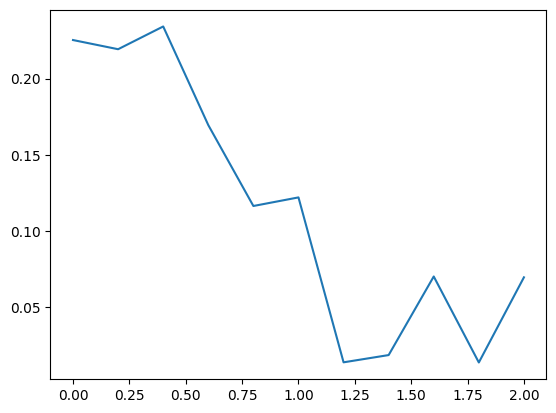

In [31]:
plt.plot(temperatures, pd.DataFrame({'corr':corr}).rolling(4, center=True, min_periods=2).mean().values.T[0])

In [191]:
def handle_unresponded_answers_binary(prompts_binary, answers_binary, verbose=False, return_n_failure=False):
    # Unaddressed responses are incorrect answers.
    
    n_failure = 0
    
    idx_prompt = 0 # prompt index
    
    # containers
    new_prompts_binary, new_answers_binary = list(), list()
    
    # read data and expected value
    with open(f'semeval2020_ulscd_eng/targets.txt', mode='r', encoding='utf-8') as f:
        lines = list()
        for line in list(f):
            target = line.replace('##newline##', '\n').replace('_vb', '').replace('_nn', '')
            line = f"""Consider the following two time periods and the target word. Did the meaning of the target word change between the two periods? Answer using 'True' or 'False'.\nTarget: {target}\nTime period 1: 1810–1860\nTime period 2: 1960–2010"""
            lines.append(line)
    
    idx_gold = 0
    with open(f'semeval2020_ulscd_eng/truth/binary.txt', mode='r', encoding='utf-8') as f:
        gold_binary = [int(g.split('\t')[1].strip()) for g in f.readlines()]
    
    for j, line in enumerate(lines):
        if prompts_binary[idx_prompt] == line:
            new_prompts_binary.append(prompts_binary[idx_prompt])
            answers_binary[idx_prompt] = answers_binary[idx_prompt]
            
            if answers_binary[idx_prompt].startswith('False'):
                answers_binary[idx_prompt] = 'False'
            if answers_binary[idx_prompt].startswith('True'):
                answers_binary[idx_prompt] = 'True'
            
            try:
                # answer in right format
                new_answers_binary.append(int(eval(answers_binary[idx_prompt])))
            except:
                if verbose:
                    print(answers_binary[idx_prompt])
                # answer in bad format
                n_failure+=1
                new_answers_binary.append(int(not gold_binary[idx_gold]))
                idx_gold+=1
            idx_prompt+=1
        else:
            # probably there was an error on the server and the prompt wasn't answered
            new_prompts_binary.append(line)
            new_answers_binary.append(int(not gold_binary[idx_gold]))
            n_failure+=1
    
    if return_n_failure:
        return new_prompts_binary, new_answers_binary, n_failure
    else:
        return new_prompts_binary, new_answers_binary


def chatgpt_api_analysis_lsc(temperature, round_=1, graded=True):
    '''Align prompts with answers'''
    
    mode = 'graded' if graded else 'binary'
    with open(f'chatgpt-conversations{round_}/LSC/{mode}/{temperature}.json', mode='r', encoding='utf-8') as f:
        chat = json.load(f)
        
    prompts = list()
    answers = list()

    for i, message in enumerate(chat):

        # empty messages to establish connection
        if i < 1:
            continue

        if i%2!=0:
            prompts.append(message['content'])
        else:
            answers.append(message['content'])
        
    return prompts, answers

def handle_unresponded_answers_graded(prompts_graded, answers_graded, verbose=False, return_n_failure=False):
    # Unaddressed responses are incorrect answers.
    
    n_failure = 0
    
    idx_prompt = 0 # prompt index
    
    # containers
    new_prompts_graded, new_answers_graded = list(), list()
    
    # read data and expected value
    with open(f'semeval2020_ulscd_eng/targets.txt', mode='r', encoding='utf-8') as f:
        lines = list()
        for line in list(f):
            target = line.replace('##newline##', '\n').replace('_vb', '').replace('_nn', '')
            line = f"""Consider the following two time periods and target word. How much has the meaning of the target word changed between the two periods? Rate the lexical semantic change on a scale from 0 to 1. Provide only a score.\nTarget: {target}\nTime period 1: 1810–1860\nTime period 2: 1960–2010"""
            lines.append(line)
    
    idx_gold = 0
    with open(f'semeval2020_ulscd_eng/truth/graded.txt', mode='r', encoding='utf-8') as f:
        gold_graded = [float(g.split('\t')[1].strip()) for g in f.readlines()]
    
    for j, line in enumerate(lines):
        if prompts_graded[idx_prompt] == line:
            new_prompts_graded.append(prompts_graded[idx_prompt])
            answers_graded[idx_prompt] = answers_graded[idx_prompt]

            try:
                new_answers_graded.append(eval(answers_graded[idx_prompt]))
            except:
                if verbose:
                    print(answers_graded[idx_prompt])
                # answer in bad format
                n_failure+=1
                new_answers_graded.append(1 - gold_graded[idx_gold])
                idx_gold+=1
            idx_prompt+=1
        else:
            # probably there was an error on the server and the prompt wasn't answered
            new_prompts_graded.append(line)
            new_answers_graded.append(1 - gold_graded[idx_gold])
            n_failure+=1
    
    if return_n_failure:
        return new_prompts_graded, new_answers_graded, n_failure
    else:
        return new_prompts_graded, new_answers_graded
    

def metrics_lsc(answers_binary, answer_graded):
    with open(f'semeval2020_ulscd_eng/truth/binary.txt', mode='r', encoding='utf-8') as f:
        gold_binary = [int(g.split('\t')[1].strip()) for g in f.readlines()]
    with open(f'semeval2020_ulscd_eng/truth/graded.txt', mode='r', encoding='utf-8') as f:
        gold_graded = [float(g.split('\t')[1].strip()) for g in f.readlines()]
    
    return round(accuracy_score(gold_binary, answers_binary), 3), spearmanr(gold_graded, answer_graded), gold_binary, gold_graded   

def metrics_lsc(answers_binary, answer_graded):
    with open(f'semeval2020_ulscd_eng/truth/binary.txt', mode='r', encoding='utf-8') as f:
        gold_binary = [int(g.split('\t')[1].strip()) for g in f.readlines()]
    with open(f'semeval2020_ulscd_eng/truth/graded.txt', mode='r', encoding='utf-8') as f:
        gold_graded = [float(g.split('\t')[1].strip()) for g in f.readlines()]
    
    return round(accuracy_score(gold_binary, answers_binary), 3), spearmanr(gold_graded, answer_graded), gold_binary, gold_graded   

In [192]:
def performance_dataframe_lsc(round_):
    df = list()

    dataset = "LSC"

    # ChatGPT - API
    for temperature in np.arange(0.0, 2.0, 0.2):
        temperature = round(temperature, 1)
        prompts_graded, answers_graded = chatgpt_api_analysis_lsc(temperature, round_, graded=True)
        prompts_binary, answers_binary = chatgpt_api_analysis_lsc(temperature, round_, graded=False)

        prompts_graded, answer_graded, n_failure_graded = handle_unresponded_answers_graded(prompts_graded, answers_graded, verbose=False, return_n_failure=True)
        prompts_binary, answers_binary, n_failure_binary = handle_unresponded_answers_binary(prompts_binary, answers_binary, verbose=False, return_n_failure=True)

        acc, correlation, gold_binary, gold_graded = metrics_lsc(answers_binary, answer_graded)
        corr, pvalue = correlation

        record = dict(model='ChatGPT API', 
                      dataset=dataset, 
                      gold_binary=gold_binary, 
                      gold_graded=gold_graded, 
                      answers_binary=answers_binary,
                      answer_graded=answer_graded,
                      temperature=temperature, 
                      n_failure_graded=n_failure_graded, 
                      n_failure_binary=n_failure_binary, 
                      acc=acc, 
                      corr=round(corr, 3),
                      pvalue=round(pvalue, 3))
        df.append(record)
    
    return pd.DataFrame(df)

In [ ]:
performance_dataframe_lsc(round_=3).sort_values('acc')

,model,dataset,gold_binary,gold_graded,answers_binary,answer_graded,temperature,n_failure_graded,n_failure_binary,acc,corr,pvalue
8,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0.6, 0, 0.8560300073, 0.6, 0.5, 0.2, 0.25, 0....",1.6,4,8,0.270,0.373,0.023
4,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0.75, 0.7, 0.7, 0.9, 0.7, 0.6, 0.8, 0.5, 0.7,...",0.8,0,6,0.486,0.033,0.846
0,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.8, 0.8, ...",0.0,0,2,0.514,0.351,0.033
1,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.8, 0.8, 0.7, 0.8, 0.8, 0.7, 0.6, 0.8, 0.7, ...",0.2,0,2,0.514,0.113,0.504
6,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","[0.6, 0.75, 0.8, 0.7, 0.8, 0.8, 0.6, 0.6, 0.75...",1.2,0,7,0.514,0.090,0.595
2,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0.7, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.8, 0.7, ...",0.4,0,2,0.568,0.006,0.973
3,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.8, 0.8, 0.6, 0.7, 0.8, 0.6, 0.7, 0.75, 0.7,...",0.6,0,1,0.568,-0.180,0.286
7,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, ...","[0.75, 0.8, 0.8560300073, 0.6, 0.75, 0.7, 0.7,...",1.4,2,8,0.568,0.112,0.510
5,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[0.7, 0.6, 0.7, 0.85, 0.8, 0.7, 0.8560300073, ...",1.0,1,2,0.649,0.123,0.468
9,ChatGPT API,LSC,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[0.1439699927, 0.1003636619, 0.4093665525, 0.3...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.2, 0.5, 0.7, 0.4, 0.9, 0.2, 0.5, 0.8, 0.8, ...",1.8,4,10,0.649,-0.029,0.866
